# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Libraries

In [20]:
import numpy as np
from numpy.linalg import inv
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Populating the interactive namespace from numpy and matplotlib


## Camera Calibration

### Load images and store corners

In [21]:
vertical_tiles = 6
horizontal_tiles = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((vertical_tiles*horizontal_tiles, 3), np.float32)
objp[:,:2] = np.mgrid[0:horizontal_tiles, 0:vertical_tiles].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (horizontal_tiles, vertical_tiles), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

### Undistort function
**PS**: This function will now work if cell above is not ran previously

In [22]:
def undistort(img):
    global objpoints, imgpoints
    
    img_size = (img.shape[1], img.shape[0])
    
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return cv2.undistort(img, mtx, dist, None, mtx)

## Set Color Scheme To Detect Line

In [23]:
def threshold_image(image, channel, thresh = (0, 255), ft='RGB'):
    assert channel >=0 and channel <=2
    
    if ft == 'HLS':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    if ft == 'HSV':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    if ft == 'RGB':
        img = image
        
    s_channel = img[:,:,channel]
    binary = np.zeros_like(s_channel)
    binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary

## Set Gradient Scheme

In [24]:
''' Returns the directional gradient given an angle threshold '''

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


''' Returns an image with the combine magnitude of gradients X & Y bounded by a threshold '''

def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output


''' Returns an image with the gradient accordingly to one direction bounded by a threshold '''

def single_axis_threshold(image, axis, sobel_kernel=3, thresh=(0,255)):
    assert axis == 'x' or axis == 'y'
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if axis == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    elif axis == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
        
    abs_sobel = np.absolute(sobel)    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) 
    
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary

## Line Detection Function
---
Let's now encapsulate everything that was done so far into a single function.

In [25]:
def binary_image(image):
    # Apply color filters
    image_HSV_V = threshold_image(image, channel=2, thresh=(220,255), ft='HSV')
    image_HLS_S = threshold_image(image, channel=2, thresh=(90,255), ft='HLS')
    # Combine color images
    combined_color = np.zeros_like(image_HSV_V)
    combined_color[((image_HSV_V == 1) & (image_HLS_S == 1))] = 1
    
    # Apply Gradient filters
    image_axis_x = single_axis_threshold(image, axis='x', sobel_kernel=5,thresh=(20,100))
    image_axis_y = single_axis_threshold(image, axis='y', sobel_kernel=3,thresh=(20,100))
    image_mag = mag_threshold(image, sobel_kernel=3,thresh=(30,100))
    image_dir = dir_threshold(image, sobel_kernel=3, thresh=(0.7, 1.3))
    # Combine Gradient images
    combined_grad = np.zeros_like(image_axis_x)
    combined_grad[((image_axis_x == 1) & (image_axis_y == 1)) 
              | ((image_mag == 1) & (image_dir == 1))] = 1

    # Combine color and gradient
    combined_all = np.zeros_like(combined_grad)
    combined_all[((combined_color == 1) | (combined_grad == 1))] = 1
    
    return combined_all

## Bird View
---
Pipeline able to change the perspective of the image with the objective of creating a "bird view".

In order to perform the warping it is necessary to identify points 4 points of the road in the original image (corners of the red polygon) and where they will be warpped to (corners of the green polygon).

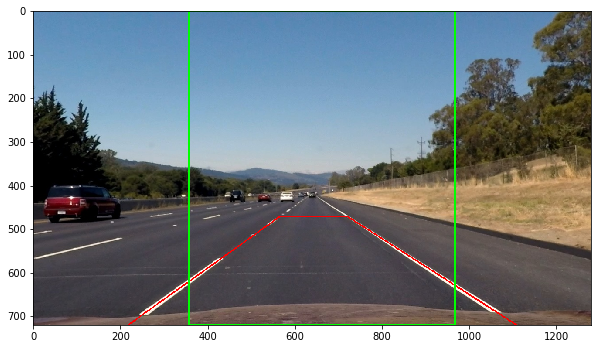

In [26]:
image = mpimg.imread('test_images/straight_lines2.jpg')
image = undistort(image)
warp_template = np.copy(image)

top_left = (567,470)
top_right = (720,470)
bottom_left = (217,720)
bottom_right = (1110,720)

src = np.float32([[bottom_left, top_left, top_right, bottom_right]])

left_bound, right_bound = (358, 968)

top_left = (left_bound,0)
top_right = (right_bound,0)
bottom_left = (left_bound,720)
bottom_right = (right_bound,720)

dst = np.float32([[bottom_left, top_left, top_right, bottom_right]])

road_trapezoid = np.array(src, np.int32)
road_square = np.array(dst, np.int32)

cv2.polylines(warp_template,[road_trapezoid],True,(255,0,0), thickness = 2)
cv2.polylines(warp_template,[road_square],True,(0,255,0), thickness = 3)

plt.imshow(warp_template)

### Function to warp images
---
Time to put the warping process inside a function.

In [27]:
''' 
    This function takes an images and returns a bird-view perspective 
    of it with the transformation matrix used 
'''

def bird_eye(image):
#     top_left = (567,470)
#     top_right = (720,470)
#     bottom_left = (217,720)
#     bottom_right = (1110,720)
    top_left = (580,460)
    top_right = (707,460)
    bottom_left = (210,720)
    bottom_right = (1110,720)
    src = np.float32([[bottom_left, top_left, top_right, bottom_right]])

    left_bound, right_bound = (360, 970)
    top_left = (left_bound,0)
    top_right = (right_bound,0)
    bottom_left = (left_bound,720)
    bottom_right = (right_bound,720)
    dst = np.float32([[bottom_left, top_left, top_right, bottom_right]])

    img_x, img_y, chn = image.shape

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (img_y, img_x))
    return M,warped

## Line Detection Functions

In [29]:
''' 
The sliding window function breaks the lines in many spices in order to fit a polynomial
that will follow the line
'''

def sliding_window_polyfit(binary, nwindows=9, margin=100, minpix=50, plot=False):
    if plot:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary, binary, binary))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    # Left Peak X position
    leftx_base = np.argmax(histogram[:midpoint])
    # Right Peak X position
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if plot:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if plot:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, left_fitx, right_fit, right_fitx, ploty


'''
Once you already have a polynomial function is not necessary to use the sliding windows
anymore, instead a function that updates the polinommial with the new image should be enough
'''

def update_polyfit(binary, left_fit, right_fit):
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, left_fitx, right_fit, right_fitx, ploty


'''
Compute the vehicle curvature having the polynomial for each line
'''

def curvatures(y_eval, left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad


pixe2meters = {'y':30/720, 'x':3.7/700}


def curvature(y_eval, fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = pixe2meters['y'] # meters per pixel in y dimension
    xm_per_pix = pixe2meters['x'] # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curve_meters = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    # Now our radius of curvature is in meters
    return curve_meters

''' Compute the distance from the lane to the center of the vehicle '''

vehicle_center = (640, 719)

def distance_center(fitx):
    return (fitx[vehicle_center[1]] - vehicle_center[0]) * pixe2meters['x']

Running the sliding window:
* Red: Left Line
* Blue: Right Line
* Yellow: polynomial aproximation
* Green: windows

Calculate the curvature of the turn in meters

### Function to Draw on Image
---
This function will draw on image and warpit back to the original shape.

In [30]:
def back_to_original(undist, warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

In [31]:
def binary_image(image):
    # Apply color filters
    image_HSV_V = threshold_image(image, channel=2, thresh=(220,255), ft='HSV')
    image_HLS_S = threshold_image(image, channel=2, thresh=(90,255), ft='HLS')
    # Combine color images
    combined_color = np.zeros_like(image_HSV_V)
    combined_color[((image_HSV_V == 1) | (image_HLS_S == 1))] = 1
    
    # Apply Gradient filters
    image_axis_x = single_axis_threshold(image, axis='x', sobel_kernel=5,thresh=(20,100))
    image_axis_y = single_axis_threshold(image, axis='y', sobel_kernel=3,thresh=(20,100))
    image_mag = mag_threshold(image, sobel_kernel=3,thresh=(30,100))
    image_dir = dir_threshold(image, sobel_kernel=3, thresh=(0.7, 1.3))
    # Combine Gradient images
    combined_grad = np.zeros_like(image_axis_x)
    combined_grad[((image_axis_x == 1) & (image_axis_y == 1)) 
              | ((image_mag == 1) & (image_dir == 1))] = 1

    # Combine color and gradient
    combined_all = np.zeros_like(combined_grad)
    combined_all[((combined_color == 1) | (combined_grad == 1))] = 1
    
    return combined_all

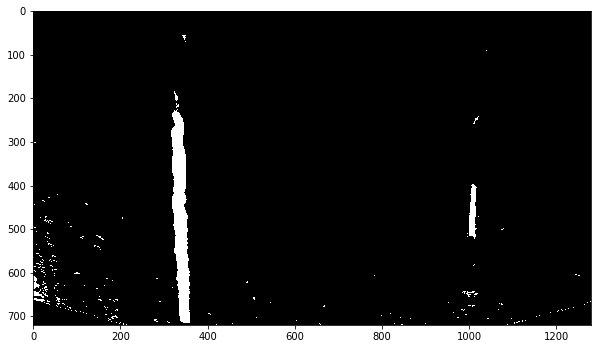

In [33]:
raw_image = mpimg.imread('Frames/frame601.jpg')

# raw_image = mpimg.imread('Frames/frame0.jpg')

# 1 - Undistort Image
image = undistort(raw_image)
# 2 - Warp Image
M, warped = bird_eye(image)
# 3 - Binnary Warped Image
binary = binary_image(warped)  

plt.imshow(binary, cmap="gray")

Curvature = 3137.03104534 632.932048153


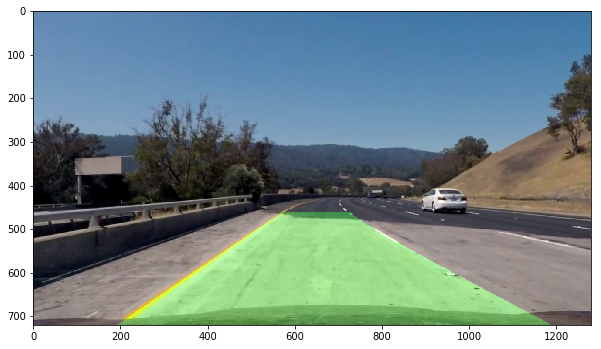

In [34]:
raw_image = mpimg.imread('Frames/frame601.jpg')

# 1 - Undistort Image
image = undistort(raw_image)
# 2 - Warp Image
M, warped = bird_eye(image)
# 3 - Binnary Warped Image
binary = binary_image(warped)    
# 4 - Apply Sliding Window
left_fit, left_fitx, right_fit, right_fitx, ploty  = sliding_window_polyfit(binary, plot=False)
# 5 - Draw Road on the Original Image
marked_image = back_to_original(image, binary, inv(M), left_fitx, right_fitx, ploty)

print("Curvature =", curvature(719, left_fitx, ploty), curvature(719, right_fitx, ploty)) 

plt.imshow(marked_image)

Curvature = 828.226431498 67939.6847176


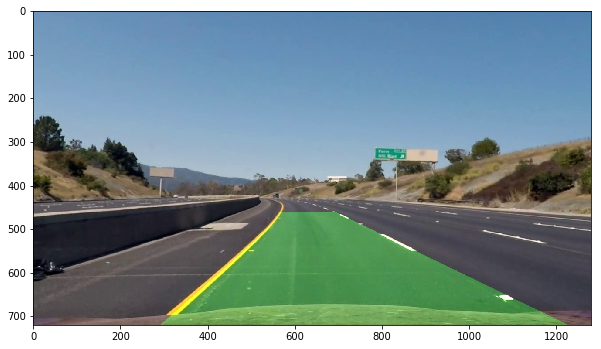

In [35]:
# raw_image = mpimg.imread('Frames/frame602.jpg')
raw_image = mpimg.imread('Frames/frame10.jpg')

# 1 - Undistort Image
image = undistort(raw_image)
# 2 - Warp Image
M, warped = bird_eye(image)
# 3 - Binnary Warped Image
binary = binary_image(warped)    
# 4 - Apply Sliding Window
left_fit, left_fitx, right_fit, right_fitx, ploty  = update_polyfit(binary, left_fit, right_fit)
# 5 - Draw Road on the Original Image
marked_image = back_to_original(image, binary, inv(M), left_fitx, right_fitx, ploty)

print("Curvature =", curvature(719, left_fitx, ploty), curvature(719, right_fitx, ploty)) 

plt.imshow(marked_image)

## Class Line
---
This class will assist detect the line in a video. It will help to define when to use the sliding window methodod or just expand on the existing line polygon.

In [36]:
class Line():
    def __init__(self):
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [37]:
# Number of fits to average on
N = 5
count_before_reset = 0
reset_threshold = 3

DEBUG_MODE = True

curvature_tolerance = 1000
x_dist_tolerance = (3.35, 3.7)
paralell_tolerance = 0.3



def curve_check(left_line, right_line):
    global curvature_tolerance
    curv_diff = abs(left_line.radius_of_curvature - right_line.radius_of_curvature)
#     print("Curve =", left_line.radius_of_curvature, right_line.radius_of_curvature, curv_diff)
    out = curv_diff < curvature_tolerance
#     print("curve_check =",out)
    return curv_diff < curvature_tolerance


def center_check(left_line, right_line):
    global x_dist_tolerance
    line_dist = abs(left_line.line_base_pos) + abs(right_line.line_base_pos)
#     print("Line Dist =", line_dist)
    out = x_dist_tolerance[0] <= line_dist <= x_dist_tolerance[1]
#     print("center_check =",out)
    return out


def paralell_check(left_line, right_line):
    global paralell_tolerance
    mean_dist = np.mean(np.abs(left_line.bestx - right_line.bestx))* pixe2meters['x']
    line_dist = abs(left_line.line_base_pos) + abs(right_line.line_base_pos)
#     print("Mean Dist =", mean_dist)
    out = abs(mean_dist - line_dist) < paralell_tolerance
#     print("paralell_check =",out)
    return out


def sanity_check(left_line, right_line):
    return curve_check(left_line, right_line) and center_check(left_line, right_line) and paralell_check(left_line, right_line)


def drawing(image, binary, M, left_line, right_line, ploty):
    global DEBUG_MODE
    
    drawed = back_to_original(image, binary, inv(M), left_line.bestx, right_line.bestx, ploty)
    
    if DEBUG_MODE:
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = 'Radius Curvature = {}(m)'.format(round(left_line.radius_of_curvature,2))
        cv2.putText(drawed,text,(10,50), font, 1.5,(255,255,255),2,cv2.LINE_AA)

        text = 'Left curve to center = {}(m)'.format(round(left_line.line_base_pos,2))
        cv2.putText(drawed,text,(10,100), font, 1.5,(255,255,255),2,cv2.LINE_AA)

        text = 'Right curve to center = {}(m)'.format(round(right_line.line_base_pos, 2))
        cv2.putText(drawed,text,(10,150), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    
    return drawed


def reset(binary):
    # Apply Sliding Window
    left_fit, left_fitx, right_fit, right_fitx, ploty = sliding_window_polyfit(binary, plot=False)   
    
    left_line = Line()
    left_line.recent_xfitted = left_fitx
    left_line.bestx = left_fitx
    left_line.best_fit = left_fit
    left_line.current_fit = left_fit
    left_line.radius_of_curvature = curvature(vehicle_center[1], left_fitx, ploty)
    left_line.line_base_pos = distance_center(left_fitx)
    left_line.allx = [left_fitx]
    left_line.ally = [ploty]
    
    right_line = Line()
    right_line.recent_xfitted = right_fitx
    right_line.bestx = right_fitx
    right_line.best_fit = right_fit
    right_line.current_fit = right_fit
    right_line.radius_of_curvature = curvature(vehicle_center[1], right_fitx, ploty)
    right_line.line_base_pos = distance_center(right_fitx)
    right_line.allx = [right_fitx]
    right_line.ally = [ploty]
    
    count_before_reset = 0
    
    return left_line, right_line, ploty

scoop = None

def smoothing(line, ploty):
    global N, scoop
    # Get the points from the past N frames
    
    pastx = np.concatenate(line.allx[-N:])
    pasty = np.concatenate(line.ally[-N:])
    
    
    # Get new averaged fit
    new_fit = np.polyfit(np.concatenate([pasty, ploty]), np.concatenate([pastx, line.recent_xfitted]), 2)
    
    # Calculate diff for the last fit
    line.diffs = new_fit - line.best_fit
    
#     print("Diffs:", line.diffs)
    
    # Update Best Fit
    line.best_fit = new_fit

    # Get best X
    line.bestx = line.best_fit[0]*ploty**2 + line.best_fit[1]*ploty + line.best_fit[2]


def handle_good_lines(left_line, right_line, ploty):
    # Update Line Fields
    # was the line detected in the last iteration?
    left_line.detected = True
    right_line.detected = True
    
    # Average N fits
    smoothing(left_line, ploty)
    smoothing(right_line, ploty)
    
    return left_line, right_line, ploty


def handle_bad_lines(left_line, right_line, ploty):
    return left_line, right_line, ploty
        

def look_ahead(binary, left_line, right_line):
    global count_before_reset, reset_threshold
    
#     print("\n@@ LOOK AHEAD\n")
    
    # Update the polyfit with new warped binary image
    left_fit, left_fitx, right_fit, right_fitx, ploty = update_polyfit(binary, left_line.best_fit, right_line.best_fit)
    
    # Update current fit/pts
    left_line.current_fit = left_fit
    left_line.recent_xfitted = left_fitx
    
    right_line.current_fit = right_fit
    right_line.recent_xfitted = right_fitx    
        
    # Update curvature
    left_line.radius_of_curvature = curvature(vehicle_center[1], left_fitx, ploty)
    right_line.radius_of_curvature = curvature(vehicle_center[1], right_fitx, ploty)
    
    # Update distance to center of the vehicle
    left_line.line_base_pos = distance_center(left_fitx)
    right_line.line_base_pos = distance_center(right_fitx)
    
    smoothing(left_line, ploty)
    smoothing(right_line, ploty)
    
    
    if sanity_check(left_line, right_line): 
        left_line.allx.append(left_line.bestx)
        left_line.ally.append(ploty)

        right_line.allx.append(right_line.bestx)
        right_line.ally.append(ploty)
        
    else:
        if count_before_reset < reset_threshold:
            count_before_reset += 1
        else:
            left_line, right_line, ploty = reset(binary)
            count_before_reset = 0
    
    return left_line, right_line, ploty

In [38]:
n_frames = 0
left_line, right_line, ploty = (None, None, None)


def final_pipeline(raw_image):
    global n_frames, left_line, right_line, ploty
    # 1 - Undistort Image
    image = undistort(raw_image)
    # 2 - Warp Image
    M, warped = bird_eye(image)
    # 3 - Binnary Warped Image
    binary = binary_image(warped)    
    
#     if(n_frames == 0):
    left_line, right_line, ploty = reset(binary)
#     else:
#         left_line, right_line, ploty = look_ahead(binary, left_line, right_line)
        
    n_frames += 1
    
    marked_image = drawing(image, binary, M, left_line, right_line, ploty)
    
    return marked_image

## Process Video

In [41]:
white_output = 'final.mp4'
n_frames = 0

# clip1 = VideoFileClip("project_video.mp4").subclip(22,27)

clip1 = VideoFileClip("./Test_Videos/project_video.mp4").subclip(0,25)

# clip1 = VideoFileClip("project_video.mp4").subclip(0,2)

# clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(final_pipeline) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video final.mp4
[MoviePy] Writing video final.mp4


100%|█████████▉| 625/626 [07:07<00:00,  1.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final.mp4 

CPU times: user 7min 42s, sys: 1min 8s, total: 8min 50s
Wall time: 7min 7s
